<a href="https://colab.research.google.com/github/andipasti/Flutter-one/blob/main/Classic_LLM_openai_28_04_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MASTER THESIS

### INITIALIZATION

In [1]:
#SETTING GLOBALS

DF_SMALL = './drive/Othercomputers/X1/code/datas_small.json'
DF_MID = './drive/Othercomputers/X1/code/datas_mid.json'
DF_LARGE = './drive/Othercomputers/X1/code/datas_large.json'

DF_SMALL_SUM = './drive/Othercomputers/X1/code/processed_summarization_per_ticket_small.json'
DF_MID_SUM = './drive/Othercomputers/X1/code/processed_summarization_per_ticket_mid.json'
DF_LARGE_SUM = './drive/Othercomputers/X1/code/processed_summarization_per_ticket_large.json'

EMBEDDINGS_SMALL = './drive/Othercomputers/X1/code/embeddings/embeddings-small-initial.npy'
EMBEDDINGS_MID = './drive/Othercomputers/X1/code/embeddings/embeddings-mid-initial.npy'
EMBEDDINGS_LARGE = './drive/Othercomputers/X1/code/embeddings/embeddings-large-initial.npy'

EMBEDDINGS_SMALL_UPDATED = './drive/Othercomputers/X1/code/embeddings/embeddings-updated-mid.npy'
EMBEDDINGS_MID_UPDATED = './drive/Othercomputers/X1/code/embeddings/embeddings-updated-mid.npy'
EMBEDDINGS_LARGE_UPDATED = './drive/Othercomputers/X1/code/embeddings/embeddings-updated-mid.npy'

MAX_DISTANCE = 2;




In [2]:
# INSTALL NEEDED LIBRARIES
!pip install -q openai==0.28
!pip install -q umap-learn
!pip install -q wordcloud

In [3]:
# IMPORTS
import os
import openai
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
import re

from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import ipywidgets as widgets
from IPython.display import display

from sklearn.metrics.pairwise import euclidean_distances

from scipy.cluster.hierarchy import fcluster

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import SpectralClustering

import umap

from sklearn.metrics import silhouette_score, davies_bouldin_score

from wordcloud import WordCloud

from google.colab import files




In [4]:
# Download necessary NLTK resources
nltk.download('punkt')  # Tokenizers
nltk.download('stopwords')  # Stopwords list for English and German
nltk.download('wordnet')

# Set up stopwords for both German and English
stop_words = set(stopwords.words('english')).union(set(stopwords.words('german')))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# CREATE ACCESS TO SECRETS
# Now you can proceed with your code that requires this environment variable
from google.colab import userdata
os.environ['HUGGINGFACE_TOKEN'] = userdata.get('HUGGINGFACE_TOKEN')

In [6]:
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
print("DONE")

DONE


In [7]:
# CHECKING

# Check if the OPENAI_API_KEY environment variable is set
if "OPENAI_API_KEY" in os.environ:
    print("OpenAI API key is set.")
else:
    print("OpenAI API key is not set.")



OpenAI API key is set.


In [8]:
# CONNECT TO DRIVE
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




---



### GETTING DATAS AND PREPROCESSING

In [9]:
# LOAD DATAS
def load_datas(config_key):
  print(config_key)
  df = pd.read_json(config_key)
  return df

In [10]:
def print_column_names(df):
  column_names = list(df.columns)
  print(column_names)

In [11]:
def drop_columns(df, columns):
  return df.drop(columns=columns, errors='ignore')

In [12]:
def replace_special_signs(df, column):
  df[column] = df[column].str.replace(r"[\n\r]", " ", regex=True)
  df[column] = df[column].str.replace(r"[^a-zA-Z0-9\s.,;!?äüöéèà']", "", regex=True)
  return df

In [13]:
def combine_columns(df, source_cols, new_col_name, separator=" "):
  df[new_col_name] = df[source_cols].astype(str).agg(separator.join, axis=1)
  return df

### RESTRUCTURE TICKET INFORMATION WITH HELP OF LLM

In [14]:
def rework_ticket_description(ticket_text, detailed_instructions, model):
    """
    Reworks a ticket description into a structured summary using the specified GPT model.

    :param ticket_text: The text of the ticket.
    :param detailed_instructions: Detailed instructions for the model.
    :param model: The model identifier to use.
    :return: Reworked ticket text.
    """
    openai.api_key = os.getenv("OPENAI_API_KEY")

    try:
        response = openai.ChatCompletion.create(
            model=model,
            messages=[
                {"role": "system", "content": detailed_instructions},
                {"role": "user", "content": ticket_text}
            ]
        )

        if response and 'choices' in response and len(response['choices']) > 0:
            reworked_text = response['choices'][0].get('message', {}).get('content', '')
            return reworked_text.strip()
        else:
            return "Failed to generate reworked text. No valid response."
    except Exception as e:
        return f"An error occurred: {str(e)}"

In [15]:
def rework_ticket_information(file_path, df, detailed_instructions, model="gpt-3.5-turbo"):
    """
    Check if a processed file exists. If not, process the tickets using GPT-Turbo and save the new data.

    :param file_path: Path to the processed file.
    :param df: DataFrame containing the ticket descriptions.
    :param detailed_instructions: Instructions for GPT model summarization.
    :param model: The model identifier to use with OpenAI's API.
    """
    if not os.path.exists(file_path):
        print("NO FILE")
        # If the file does not exist, apply the function to rework ticket descriptions
        df['reworked_information'] = df['combined_text'].apply(lambda x: rework_ticket_description(x, detailed_instructions, model))
        df.to_json(file_path, orient='records', lines=True)
        files.download(file_path)
        print("Processed new data and saved to file.")
    else:
        print("FILE EXISTS")
        # Load the existing file if it already exists
        print("FILEPATH: ", file_path)
        print(df)
        pd.read_json(file_path, lines=True)
        print("File exists. Loaded existing data.")

    return df


In [16]:
def clean_datas_in_col(text):
    """ Cleans the text data by removing specific words and non-alphabetical characters. """
    if not isinstance(text, str):
        return ""  # Return empty string if text is not a string

    text = text.lower()
    specific_unwanted_words = ['reported problem', 'ticket', 'summary', 'affected systems', 'reported problem', 'issue']
    pattern = r'\b(?:' + '|'.join(specific_unwanted_words) + r')\b'
    text = re.sub(pattern, '', text)

    words = nltk.word_tokenize(text)
    words = [word for word in words if word not in stop_words and word.isalpha()]

    return ' '.join(words)

def clean_datas(df, column_name):
    """ Applies text cleaning to a specified column in the DataFrame. """
    df[column_name + '_cleaned'] = df[column_name].apply(clean_datas_in_col)
    return df



## CREATE EMBEDDING

In [95]:
# USE OPENAI MODEL TO CREATE EMBEDDINGS OUT OF REWORKED INFORMATION

# Function to get embeddings from OpenAI

def get_embeddings_impl(texts, embeddings_file_path):

  # Explicitly set the OpenAI API key
  openai.api_key = os.getenv("OPENAI_API_KEY")

  if not os.path.exists(embeddings_file_path):
    embeddings = []
    for text in texts:
        response = openai.Embedding.create(
            input=text,
            engine="text-embedding-ada-002"
        )
        embeddings.append(response['data'][0]['embedding'])

    # save:
    np.save(embeddings_file_path, embeddings)
  else:
    embeddings = np.load(embeddings_file_path)
    print("EMBEDDING read: ", embeddings.shape[0])

  return np.array(embeddings)

'''

def get_embeddings_impl(texts, embeddings_file_path):
  """
  Retrieves or generates embeddings for a list of texts using OpenAI's API and stores/retrieves them from a file.

  :param texts: List of text strings to embed.
  :param embeddings_file_path: Path to save or load the embeddings numpy file.
  :return: Numpy array of embeddings.
  """
  # Explicitly set the OpenAI API key
  openai.api_key = os.getenv("OPENAI_API_KEY")

  if not os.path.exists(embeddings_file_path):
      if not texts:
          raise ValueError("Texts list is empty, no embeddings to generate.")

      embeddings = []
      for text in texts:
          response = openai.Embedding.create(
              input=text,
              engine="text-embedding-ada-002"
          )
          if 'data' in response and response['data']:
              embeddings.append(response['data'][0]['embedding'])
          else:
              embeddings.append(np.zeros(1024))  # Assuming embedding size of 1024, adjust as necessary

      # Save the embeddings if any were successfully generated
      np.save(embeddings_file_path, embeddings)
  else:
      embeddings = np.load(embeddings_file_path)
      print("EMBEDDING read: ", embeddings.shape)

  embeddings_array = np.array(embeddings)
  if embeddings_array.ndim != 2:
      raise ValueError(f"Expected 2D array for embeddings, got shape {embeddings_array.shape}")

  return embeddings_array


'''

'\n\ndef get_embeddings_impl(texts, embeddings_file_path):\n  """\n  Retrieves or generates embeddings for a list of texts using OpenAI\'s API and stores/retrieves them from a file.\n\n  :param texts: List of text strings to embed.\n  :param embeddings_file_path: Path to save or load the embeddings numpy file.\n  :return: Numpy array of embeddings.\n  """\n  # Explicitly set the OpenAI API key\n  openai.api_key = os.getenv("OPENAI_API_KEY")\n\n  if not os.path.exists(embeddings_file_path):\n      if not texts:\n          raise ValueError("Texts list is empty, no embeddings to generate.")\n\n      embeddings = []\n      for text in texts:\n          response = openai.Embedding.create(\n              input=text,\n              engine="text-embedding-ada-002"\n          )\n          if \'data\' in response and response[\'data\']:\n              embeddings.append(response[\'data\'][0][\'embedding\'])\n          else:\n              embeddings.append(np.zeros(1024))  # Assuming embedding si

TODO:  
- different models
- optimize preprocessing (normalize, stopwords, lemmatization,...)
- fine-tuning embeddings /hybrid approach (using z.b randomForest after clustering)
- dimensionality reduction (PCA f.e.)


## CREATE CLUSTERS V1

### WARD

In [18]:
def plot_dendrogram(Z, title='Hierarchical Clustering Dendrogram', xlabel='Sample index or (Cluster size)', ylabel='Distance'):
    """
    Plot a dendrogram to visualize hierarchical clustering results.

    :param Z: Linkage matrix from hierarchical clustering.
    :param title: Title of the dendrogram.
    :param xlabel: Label for the x-axis.
    :param ylabel: Label for the y-axis.
    """
    if Z is None:
        print("No linkage matrix provided for plotting.")
        return

    plt.figure(figsize=(25, 10))
    dendrogram(
        Z,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
    )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


### DBSCAN

In [19]:
# Optional: Plot clusters if you wish to visualize
# plot_clusters_with_umap(matrix, clusters)


def plot_clusters(matrix, clusters):
    # Perform dimensionality reduction for visualization if it's not 2D
    tsne = TSNE(n_components=2, random_state=42)
    matrix_2d = tsne.fit_transform(matrix)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(matrix_2d[:, 0], matrix_2d[:, 1], c=clusters, cmap='viridis')
    plt.colorbar(scatter)
    plt.title('DBSCAN Clustering Visualization')
    plt.xlabel('TSNE Dimension 1')
    plt.ylabel('TSNE Dimension 2')
    plt.show()

def plot_clusters_with_umap(matrix, clusters):
    # Use UMAP for dimensionality reduction
    reducer = umap.UMAP(random_state=42)
    matrix_2d = reducer.fit_transform(matrix)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(matrix_2d[:, 0], matrix_2d[:, 1], c=clusters, cmap='viridis')
    plt.colorbar(scatter)
    plt.title('DBSCAN Clustering Visualization with UMAP')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.show()


In [20]:
# Assuming 'matrix' is your embeddings matrix obtained from get_openai_embeddings function
def perform_kmeans_clustering(matrix, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
    clusters = kmeans.fit_predict(matrix)
    return clusters


In [21]:
def perform_dbscan_clustering(matrix, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(matrix)
    return clusters


In [22]:
def perform_spectral_clustering(matrix, n_clusters):
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
                                  assign_labels='kmeans', random_state=42)
    clusters = spectral.fit_predict(matrix)
    return clusters


In [23]:
def perform_hierarchical_clustering(matrix, num_clusters, method='ward'):
    Z = linkage(matrix, method=method)
    clusters = fcluster(Z, num_clusters, criterion='maxclust')
    return clusters

### CHECK HOW MANY CLUSTERS WOULD BE USEFUL (KMEANS)

In [24]:
def calculate_wcss(matrix, max_clusters=10):
    """
    Calculate the Within-Cluster Sum of Squares (WCSS) for different numbers of clusters in K-Means.

    :param matrix: 2D numpy array of data points.
    :param max_clusters: Maximum number of clusters to test.
    :return: List of WCSS values.
    """
    wcss = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=15, random_state=0)
        kmeans.fit(matrix)
        wcss.append(kmeans.inertia_)
    return wcss


In [115]:
def determine_optimal_clusters_elbow(matrix, max_clusters=10):
    # Handle potential NaN values robustly
    if np.isnan(matrix).any():
        print("Matrix contains NaN values. Consider removing or imputing these values.")
        matrix = np.nan_to_num(matrix, nan=np.nanmean(matrix, axis=0))

    # Ensure it's a 2D array suitable for KMeans
    if len(matrix.shape) == 1:
        matrix = matrix.reshape(-1, 1)

    wcss = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
        kmeans.fit(matrix)
        wcss.append(kmeans.inertia_)

    # Plot WCSS to see the elbow
    plt.plot(range(1, max_clusters + 1), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

    # Calculate the second derivative of the WCSS
    # The first derivative shows the rate of change between each point
    # The second derivative shows the change in the rate of change
    second_derivative = np.diff(wcss, 2)

    # The elbow is typically considered where the second derivative is minimum
    elbow_point = np.argmin(second_derivative) + 2  # +2 because np.diff reduces the array size by 1 each time

    return elbow_point


In [26]:
def visualize_umap(embeddings, clusters):
    umap_reducer = umap.UMAP()
    umap_result = umap_reducer.fit_transform(embeddings)
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=clusters, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter)
    plt.title('UMAP Visualization of Clusters')
    plt.xlabel('UMAP Feature 1')
    plt.ylabel('UMAP Feature 2')
    plt.show()

In [27]:
def clean_text(text):
    """
    Cleans text by removing specific unwanted words and filtering out non-alphabetical characters.

    :param text: Text to be cleaned.
    :return: Cleaned text as a string.
    """
    if not isinstance(text, str):
        return ""  # Return empty string if text is not a string

    # List of specific unwanted words
    unwanted_words = ['reported problem', 'ticket', 'summary', 'affected systems', 'issue']
    pattern = r'\b(?:' + '|'.join(unwanted_words) + r')\b'

    text = text.lower()
    text = re.sub(pattern, '', text)

    words = nltk.word_tokenize(text)
    words = [word for word in words if word not in stop_words and word.isalpha()]

    return ' '.join(words)

def clean_datas(df, column_name):
    """
    Applies text cleaning to a specified column in the DataFrame and updates the column directly.

    :param df: DataFrame containing the data.
    :param column_name: Name of the column to clean.
    :return: DataFrame with cleaned text in the same column.
    """
    df[column_name + '_cleaned'] = df[column_name].apply(clean_text)
    return df


CHECKPOINT 1: EVALUATE CLUSTERING

In [28]:
def plot_clusters_with_umap(matrix, clusters, title):
    umap_reducer = umap.UMAP(random_state=42)
    umap_result = umap_reducer.fit_transform(matrix)
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=clusters, cmap='viridis')
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('UMAP Feature 1')
    plt.ylabel('UMAP Feature 2')
    plt.show()


In [29]:
# Davies-Bouldin Index

SHOWING IN A WORD CLOUD - CLUSTERS

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

def generate_wordclouds(df):
    unique_clusters = np.unique(df['cluster_label'])
    print("UNIQUE CLUSTERS: ", unique_clusters)
    for cluster_num in unique_clusters:

        cluster_data = df[df['cluster_label'] == cluster_num]

        tfidf_vectorizer = TfidfVectorizer(stop_words='english')
        tfidf_matrix = tfidf_vectorizer.fit_transform(cluster_data['cleaned_information'])
        terms = tfidf_vectorizer.get_feature_names_out()
        scores = tfidf_matrix.sum(axis=0).A1
        freqs = dict(zip(terms, scores))
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freqs)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f'Word Cloud for Cluster {cluster_num}')
        plt.show()


In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

def generate_cluster_labels(df):
    unique_clusters = np.unique(df['cluster_label'])
    labels = []
    print("CLUSTERS IN GENERATE CLUSTER FUNC ", unique_clusters)
    for cluster_num in unique_clusters:

        cluster_data = df[df['cluster_label'] == cluster_num]

        tfidf_vectorizer = TfidfVectorizer(stop_words='english')
        tfidf_matrix = tfidf_vectorizer.fit_transform(cluster_data['cleaned_information'])
        terms = np.array(tfidf_vectorizer.get_feature_names_out())[tfidf_matrix.sum(axis=0).argsort()[0, ::-1]].flat[:5]
        label = ', '.join(terms)
        labels.append(label)
        print(f"Cluster {cluster_num} label: {label}")
    return labels


In [32]:
import openai

# Generate meaningful labels for each cluster using GPT-3.5 Turbo
def create_gpt3_labels(labels):
    cluster_labels = []
    for label in labels:

        #prompt = "Please generate a concise label for the following cluster of terms."
        prompt = f"Generate a very specific and descriptive maximum 3-words-label for a cluster of topics involving: {label}. Aim for precision and relevance in a technical context. it is all about a webapplication where users like teachers or scholars can see timetable, do enrolments, add and confirm absences and many more."

        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": prompt},
                {"role": "user", "content": label}
            ]
        )
        new_label = response['choices'][0]['message']['content'].strip()
        cluster_labels.append(new_label)
    return cluster_labels


In [33]:
def generate_wordclouds(df, text_column, label_column):
    """
    Generates and displays word clouds for each cluster.

    :param df: DataFrame containing the cluster labels and text data.
    :param text_column: Name of the column in df that contains the text data.
    :param label_column: Name of the column in df that contains the cluster labels.
    """
    unique_clusters = df[label_column].unique()
    for cluster in unique_clusters:
        cluster_text = " ".join(df[df[label_column] == cluster][text_column].dropna())
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Word Cloud for Cluster {cluster}")
        plt.show()


## CATEGORIZING NEW TICKETS TO ONE OF THE CLUSTERS WITHOUT THE NEED OF DOING THE WHOLE CLUSTERSTUFF ETC AGAIN

In [34]:
def plot_umap(embeddings, cluster_labels, new_ticket_index):
    reducer = umap.UMAP()
    embedding_2d = reducer.fit_transform(embeddings)
    plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=cluster_labels, cmap='Spectral', alpha=0.6)
    plt.scatter(embedding_2d[new_ticket_index, 0], embedding_2d[new_ticket_index, 1], c='red', s=100, edgecolors='k')  # Highlight new ticket
    plt.title("UMAP Projection of Ticket Embeddings")
    plt.colorbar()
    plt.show()

In [35]:
def check_new_ticket(embeddings, reworked_ticket_text, df, update_path, threshold=0.5):
    print("Starting check_new_ticket...")

    # get last embedding
    new_embedding = embeddings[-1]
    all_embeddings_exept_last = embeddings[:-1]

    # Check if the DataFrame is empty or the existing_embeddings are insufficient
    if df.empty or len(embeddings) <= 1:  # Ensure there's at least one existing ticket besides the new one
        print("No existing tickets to compare or DataFrame is empty.")
        new_label = 0  # Starting with a new cluster if no valid data exists
    else:
        # Exclude the new embedding which is presumably the last one added
        print(new_embedding)
        # Calculate distances to all existing embeddings
        distances = euclidean_distances([new_embedding], all_embeddings_exept_last)
        min_distance = distances.min()

        print("Distance: ", distances.min())
        # Decide on the cluster label based on distance
        if min_distance > threshold:
          print("NEUES CLUSTER")
          new_label = df['cluster_label'].max() + 1 if not df.empty else 0
          #new_label = 0
          print(f"Assigning new cluster label: {new_label}")
        else:
            print("BESTEHENDES CLUSTER")
            closest_index = distances.argmin()
            print("CLOSEST INDEX: ", closest_index)
            if closest_index < len(df):
                new_label = df.iloc[closest_index]['cluster_label']
                #new_label = 0
                print(f"Assigning existing cluster label: {new_label}")
            else:
                print(f"Error: Closest index {closest_index} out of bounds for DataFrame of length {len(df)}")
                return df, None  # Return None if there's an index error

    # Append the new ticket's data as a new row to the DataFrame

    df.loc[len(df)-1, 'cluster_label'] =  new_label

    new_ticket_index = df.index[-1]  # Get the index of the newly added ticket
    return df, new_ticket_index

In [36]:
def get_openai_embeddings_addon(texts, initial_path, update_path):
    # Check and load initial embeddings or initialize an empty array

    new_embeddings = []
    for text in texts:
        response = openai.Embedding.create(input=text, engine="text-embedding-3-large")
        new_embeddings.append(response['data'][0]['embedding'])

    return new_embeddings

## CREATE ANOTHER TICKET AND RECLUSTER IT

In [37]:
initial_path = EMBEDDINGS_MID
update_path = EMBEDDINGS_MID_UPDATED
new_ticket = "eine gurke kommt plötzlich aus meinem handy anstelle einer banane."

reworked_ticket_text = rework_ticket_description_with_gptturbo(new_ticket)
print(f"Length of existing_embeddings: {len(embeddings)}")
print(f"Number of rows in df: {len(df)}")
df.loc[len(df), ['issue_title', 'reworked_information', 'cleaned_information']] = ["MY TEST TITLE FOR NEW ISSUES", reworked_ticket_text, reworked_ticket_text]


new_embeddings = get_openai_embeddings_addon([reworked_ticket_text], initial_path, update_path)[-1]

# Combine new embeddings with existing ones
new_embeddings = np.array(new_embeddings)
embeddings = np.vstack([embeddings, new_embeddings]) if embeddings.size else new_embeddings

# Save updated embeddings
np.save(update_path, embeddings)
print(f"Length of existing_embeddings: {len(embeddings)}")
print(f"Number of rows in df: {len(df)}")

#embeddings = np.load(update_path)[:-2]
#embeddings = np.load(update_path)[:-1]
print(f"Length of existing_embeddings: {len(embeddings)}")


NameError: name 'rework_ticket_description_with_gptturbo' is not defined

In [ ]:
print(f"Length of existing_embeddings: {len(embeddings)}")
print(f"Number of rows in df: {len(df)}")

In [ ]:
df


In [ ]:
#df = df.drop(len(df)-1)
#embeddings = np.load(update_path)[:-1]

In [ ]:
#print(reworked_ticket_text)

In [ ]:

# Call the check_new_ticket function
df, new_ticket_index = check_new_ticket(embeddings, reworked_ticket_text, df, update_path)



In [ ]:
plot_umap(embeddings, df['cluster_label'], new_ticket_index)

In [ ]:
 # Perform clustering

#clusters, Z = perform_hierarchical_clustering(embeddings, MAX_DISTANCE)

#df['cluster_label'] = clusters  # Assign cluster labels to DataFrame

# Visualize using UMAP
#visualize_umap(embeddings, clusters)

# Generate word clouds for each cluster
generate_wordclouds(df)


# Generate labels using TF-IDF
labels = generate_cluster_labels(df)


# Create meaningful labels using GPT-3.5 Turbo
cluster_labels_reworked = create_gpt3_labels(labels)


# Create and display final cluster information
cluster_data = pd.DataFrame({
    'ClusterNumber': range(1, len(cluster_labels_reworked) + 1),
    'ClusterLabel': cluster_labels_reworked,
    'OriginalLabels': labels
})

print(cluster_data)



In [ ]:
# Display all rows where 'cluster_label' equals 5
filtered_df = df[df['cluster_label'] == 6]

print(filtered_df)

In [ ]:
import umap
import matplotlib.pyplot as plt

'''
def plot_umap_updated(embeddings, cluster_labels):
    # Initialize UMAP
    print("LABELS: ", cluster_labels)
    reducer = umap.UMAP(random_state=42)
    # Transform the embeddings to 2D for visualization
    embedding_2d = reducer.fit_transform(embeddings)

    # Create a scatter plot
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=cluster_labels, cmap='Spectral', s=50, alpha=0.6)
    plt.colorbar(scatter)
    plt.title('UMAP Projection of Clusters')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.show()

# Assuming 'embeddings' and 'cluster_labels' are defined
plot_umap_updated(embeddings, df['cluster_label'])

'''

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import umap

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import umap.umap_ as umap

# Example DataFrame 'cluster_data' which you should already have
# cluster_data = pd.DataFrame({
#     'ClusterNumber': [1, 2, 3, 4, 5],
#     'ClusterLabel': ['Tech Support', 'Product Feedback', 'Complaints', 'Inquiries', 'Other'],
#     'OriginalLabels': ['support', 'feedback', 'complaint', 'inquiry', 'other']
# })

# Assuming cluster_data is predefined as above
label_map = .set_index('ClusterNumber')['ClusterLabel'].to_dict()

# Define a list of colors (or use a matplotlib colormap)
colors = plt.cm.Spectral(np.linspace(0, 1, len(cluster_data)))
color_map = dict(zip(cluster_data['ClusterNumber'], colors))

def plot_umap_updated(embeddings, cluster_ids):
    # Initialize UMAP
    reducer = umap.UMAP(random_state=42)
    embedding_2d = reducer.fit_transform(embeddings)

    plt.figure(figsize=(10, 7))

    # Iterate over each unique cluster id found in the dataset
    for cluster_id in np.unique(cluster_ids):
        # Find points that belong to the current cluster
        idx = np.where(cluster_ids == cluster_id)
        # Use label and color mappings, default to 'grey' if not found
        cluster_label = label_map.get(cluster_id, 'Unknown')
        cluster_color = color_map.get(cluster_id, 'grey')

        # Plot each cluster using assigned colors and add label for the legend
        plt.scatter(embedding_2d[idx, 0], embedding_2d[idx, 1], color=cluster_color, label=cluster_label, s=50, alpha=0.6)

    plt.legend(title='Cluster Labels')
    plt.title('UMAP Projection of Clusters with Custom Labels')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.show()

# Assuming 'embeddings' and 'cluster_ids' are defined appropriately
plot_umap_updated(embeddings, df['cluster_label'])


In [38]:
import plotly.express as px
import umap.umap_ as umap

def plot_umap_interactive(embeddings, cluster_ids, titles):
    # Initialize UMAP
    reducer = umap.UMAP(random_state=42)
    embedding_2d = reducer.fit_transform(embeddings)

    # Create a DataFrame for the Plotly scatter plot
    df_plot = pd.DataFrame({
        'UMAP Dimension 1': embedding_2d[:, 0],
        'UMAP Dimension 2': embedding_2d[:, 1],
        'Cluster': [label_map[cid] for cid in cluster_ids],
        'Title': titles
    })

    # Create a scatter plot
    fig = px.scatter(df_plot, x='UMAP Dimension 1', y='UMAP Dimension 2',
                     color='Cluster', labels={'color': 'Cluster Label'},
                     hover_data=['Title'],
                     title='UMAP Projection of Clusters')
    fig.update_traces(marker=dict(size=12, line=dict(width=2, color='DarkSlateGrey')), selector=dict(mode='markers'))
    fig.show()

# Example usage
plot_umap_interactive(embeddings, df['cluster_label'], df['issue_title'])


NameError: name 'embeddings' is not defined

In [39]:
df

NameError: name 'df' is not defined

**3. Adaptability and accuracy of the system**
Goal: Without manual intervention, the system should not only correctly categorize new tickets with
new content, but also adapt the ticket categories accordingly.
Deliverable: A real-time classification engine that adapts to new data in real time. This module is
further developed through transfer learning.

In [40]:
from sklearn.manifold import TSNE

def plot_tsne(embeddings, cluster_labels):
    # Initialize t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    # Transform the embeddings to 2D
    embedding_2d = tsne.fit_transform(embeddings)

    # Plotting
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=cluster_labels, cmap='Spectral', s=50, alpha=0.6)
    plt.colorbar(scatter)
    plt.title('t-SNE Projection of Clusters')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

plot_tsne(embeddings, df['cluster_label'])


NameError: name 'embeddings' is not defined

# PLAYGROUND

In [41]:
'''
def perform_kmeans_clustering(data, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    clusters = kmeans.fit_predict(data)
    return clusters

def perform_hierarchical_clustering(data, max_distance=2):
    Z = linkage(data, method='ward')
    clusters = fcluster(Z, max_distance, criterion='distance')
    return clusters

def perform_spectral_clustering(data, n_clusters=3):
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', assign_labels='kmeans', random_state=42)
    clusters = spectral.fit_predict(data)
    return clusters
'''

"\ndef perform_kmeans_clustering(data, n_clusters=3):\n    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)\n    clusters = kmeans.fit_predict(data)\n    return clusters\n\ndef perform_hierarchical_clustering(data, max_distance=2):\n    Z = linkage(data, method='ward')\n    clusters = fcluster(Z, max_distance, criterion='distance')\n    return clusters\n\ndef perform_spectral_clustering(data, n_clusters=3):\n    spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', assign_labels='kmeans', random_state=42)\n    clusters = spectral.fit_predict(data)\n    return clusters\n"

In [42]:
def compute_clustering_metrics(matrix, labels):
    # Check if there is more than one unique cluster and less than the length of the dataset
    if len(set(labels)) > 1 and len(set(labels)) < len(matrix):
        silhouette = silhouette_score(matrix, labels)
        davies = davies_bouldin_score(matrix, labels)
    else:
        silhouette, davies = -1, -1  # Use -1 to indicate an invalid clustering evaluation
    return silhouette, davies


In [129]:
def main_clustering_and_evaluation(matrix, num_clusters):
    dbscan_clusters = perform_dbscan_clustering(matrix)
    hierarchical_clusters = perform_hierarchical_clustering(matrix, num_clusters)
    kmeans_clusters = perform_kmeans_clustering(matrix, num_clusters)
    spectral_clusters = perform_spectral_clustering(matrix, num_clusters)

    #evaluate_clusters(matrix, dbscan_clusters, hierarchical_clusters, kmeans_clusters, spectral_clusters)

    evaluate_clusters(matrix,
                  dbscan=dbscan_clusters,
                  hierarchical=hierarchical_clusters,
                  kmeans=kmeans_clusters,
                  spectral=spectral_clusters)


In [44]:
# Define configurations
data_config = {
    'small': DF_SMALL,
    'mid': DF_MID,
    'large': DF_LARGE,
}

embedding_config = {
    'small_initial': EMBEDDINGS_SMALL,
    'mid_initial': EMBEDDINGS_MID,
    # Add more configurations here
}

clustering_config = {
  'dbscan': perform_dbscan_clustering,
    'kmeans': perform_kmeans_clustering,
    'ward': perform_hierarchical_clustering,
    'spectral': perform_spectral_clustering,
    # Add more clustering methods here
}


In [45]:
# Define your functions here
def load_data(config_key):
    return load_datas(config_key)

In [46]:
def preprocess_data(df):
    df = drop_columns(df, ['journal_id', 'journal_created_on', 'journal_author', 'journal_notes', 'issue_id'])
    df = replace_special_signs(df, 'issue_description')
    df = combine_columns(df, ['issue_title', 'issue_description'], 'combined_text')
    return df


In [47]:
def rework_datas(df, file_path_sum):
  detailed_instructions = ("You are a highly capable technical supporter. For each issue, provide a summary "
                          "categorized under the following headers:\n"
                          "- Issue: [Specify the type of issue e.g., Support, IT-Systems, Development]\n"
                          "- Affected Systems: [List affected systems e.g., VDI, Email Servers, etc.]\n"
                          "- Reported Problem: [Describe the reported problem e.g., no connection, slow performance, etc.]")

  print("FILE PATH: ", file_path_sum)
  print(df)

  df = rework_ticket_information(file_path_sum, df, detailed_instructions)
  return df

In [99]:
def get_embeddings(EMBEDDING):
  texts = df['reworked_information'].tolist()
  embeddings = get_embeddings_impl(texts, EMBEDDING)
  return embeddings

In [116]:
def determine_cluster_count(embeddings):
  num_clusters = determine_optimal_clusters_elbow(embeddings)
  print("NUM", num_clusters)
  return num_clusters

In [123]:
def get_cluster_data(matrix, num_clusters):

    # Get cluster labels from each algorithm
    dbscan_clusters = perform_dbscan_clustering(matrix)
    hierarchical_clusters = perform_hierarchical_clustering(matrix, num_clusters)
    kmeans_clusters = perform_kmeans_clustering(matrix, num_clusters)
    spectral_clusters = perform_spectral_clustering(matrix, num_clusters)

    return dbscan_clusters, hierarchical_clusters, kmeans_clusters, spectral_clusters


In [138]:
def visualize_clusters(embeddings, dbscan_clusters, hierarchical_clusters, kmeans_clusters, spectral_clusters):
    plot_clusters_with_umap(embeddings, kmeans_clusters, 'K-Means Clustering with UMAP')
    plot_clusters_with_umap(embeddings, dbscan_clusters, 'DBSCAN Clustering with UMAP')  # Assuming 'clusters' from DBSCAN
    plot_clusters_with_umap(embeddings, hierarchical_clusters, 'Hierarchical Clustering with UMAP')  # Assuming 'cluster_labels' from Ward
    plot_clusters_with_umap(embeddings, spectral_clusters, 'Spectral Clustering with UMAP')

In [51]:
def evaluate_clusters(matrix, **cluster_labels):
    for name, labels in cluster_labels.items():
        silhouette, davies = compute_clustering_metrics(matrix, labels)
        print(f"{name} Silhouette: {silhouette}, {name} Davies-Bouldin: {davies}")


In [52]:
def create_wordclouds_and_labels():
  # Generate word clouds
  generate_wordclouds(df, text_column="Text", label_column="ClusterLabel")

  # Generate initial labels using TF-IDF or similar
  initial_labels = generate_cluster_labels(df)

  # Create meaningful labels using GPT-3.5 Turbo
  cluster_labels_reworked = create_gpt3_labels(initial_labels)

  # Create and display final cluster information
  cluster_data = pd.DataFrame({
      'ClusterNumber': range(1, len(cluster_labels_reworked) + 1),
      'ClusterLabel': cluster_labels_reworked,
      'OriginalLabels': initial_labels
  })

  print(cluster_data)


#TESTING

In [53]:
#TESTING
# Create widgets for interactivity

df = load_data(DF_SMALL)
file_path = DF_SMALL
file_path_sum = DF_SMALL_SUM


./drive/Othercomputers/X1/code/datas_small.json


In [54]:
df = preprocess_data(df)
df


,issue_title,issue_description,combined_text
0,[MBA#1127156] Layout-Anpassung auf Typo 3 - We...,Guten Morgen Ich habe eine eher spezielle A...,[MBA#1127156] Layout-Anpassung auf Typo 3 - We...
1,[MBA#1128940] Zimbra Störung komplette Schule:...,Guten Morgen allerseits Schule KSLZH Melde...,[MBA#1128940] Zimbra Störung komplette Schule:...
2,Fwd: [MBA#1128639] AW: Druckereinstellungen Se...,Hallo Seit der Umstellung auf Leunet hat di...,Fwd: [MBA#1128639] AW: Druckereinstellungen Se...
3,KEN: mobile App aufschalten,Einfach mal alle Module freischalten,KEN: mobile App aufschalten Einfach mal alle M...


In [60]:
df = rework_datas(df, file_path_sum)

FILE PATH:  ./drive/Othercomputers/X1/code/processed_summarization_per_ticket_small.json
                                         issue_title  \
0  [MBA#1127156] Layout-Anpassung auf Typo 3 - We...   
1  [MBA#1128940] Zimbra Störung komplette Schule:...   
2  Fwd: [MBA#1128639] AW: Druckereinstellungen Se...   
3                        KEN: mobile App aufschalten   

                                   issue_description  \
0  Guten Morgen    Ich habe eine eher spezielle A...   
1  Guten Morgen allerseits    Schule KSLZH  Melde...   
2  Hallo    Seit der Umstellung auf Leunet hat di...   
3               Einfach mal alle Module freischalten   

                                       combined_text  
0  [MBA#1127156] Layout-Anpassung auf Typo 3 - We...  
1  [MBA#1128940] Zimbra Störung komplette Schule:...  
2  Fwd: [MBA#1128639] AW: Druckereinstellungen Se...  
3  KEN: mobile App aufschalten Einfach mal alle M...  
NO FILE


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processed new data and saved to file.


In [61]:
df

,issue_title,issue_description,combined_text,reworked_information
0,[MBA#1127156] Layout-Anpassung auf Typo 3 - We...,Guten Morgen Ich habe eine eher spezielle A...,[MBA#1127156] Layout-Anpassung auf Typo 3 - We...,- **Issue:** Development\n- **Affected Systems...
1,[MBA#1128940] Zimbra Störung komplette Schule:...,Guten Morgen allerseits Schule KSLZH Melde...,[MBA#1128940] Zimbra Störung komplette Schule:...,- **Issue:** Support\n- **Affected Systems:** ...
2,Fwd: [MBA#1128639] AW: Druckereinstellungen Se...,Hallo Seit der Umstellung auf Leunet hat di...,Fwd: [MBA#1128639] AW: Druckereinstellungen Se...,"- Issue: Support\n- Affected Systems: VDI, Can..."
3,KEN: mobile App aufschalten,Einfach mal alle Module freischalten,KEN: mobile App aufschalten Einfach mal alle M...,- Issue: Support\n- Affected Systems: Mobile A...


In [62]:
clean_datas(df, 'reworked_information')

,issue_title,issue_description,combined_text,reworked_information,reworked_information_cleaned
0,[MBA#1127156] Layout-Anpassung auf Typo 3 - We...,Guten Morgen Ich habe eine eher spezielle A...,[MBA#1127156] Layout-Anpassung auf Typo 3 - We...,- **Issue:** Development\n- **Affected Systems...,development website kantonsschule wiedikon kwi...
1,[MBA#1128940] Zimbra Störung komplette Schule:...,Guten Morgen allerseits Schule KSLZH Melde...,[MBA#1128940] Zimbra Störung komplette Schule:...,- **Issue:** Support\n- **Affected Systems:** ...,support zimbra email servers domains users sch...
2,Fwd: [MBA#1128639] AW: Druckereinstellungen Se...,Hallo Seit der Umstellung auf Leunet hat di...,Fwd: [MBA#1128639] AW: Druckereinstellungen Se...,"- Issue: Support\n- Affected Systems: VDI, Can...",support vdi canon imagerunner advance printer ...
3,KEN: mobile App aufschalten,Einfach mal alle Module freischalten,KEN: mobile App aufschalten Einfach mal alle M...,- Issue: Support\n- Affected Systems: Mobile A...,support mobile app user requesting activate mo...


In [118]:
embeddings = get_embeddings(EMBEDDINGS_SMALL)


EMBEDDING read:  315


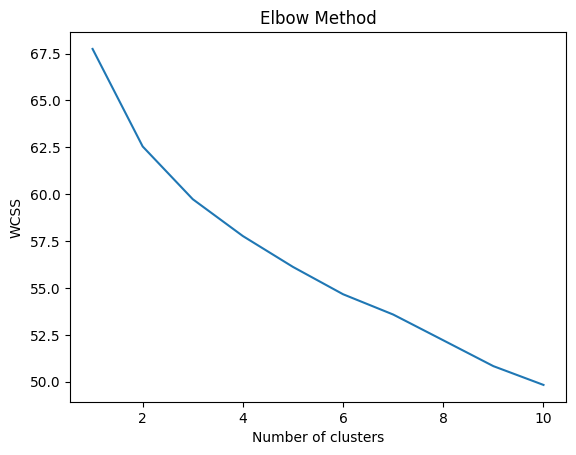

NUM 7


In [117]:
cluster_count = determine_cluster_count(embeddings)

In [119]:
print(cluster_count)

7


In [135]:
dbscan_clusters, hierarchical_clusters, kmeans_clusters, spectral_clusters = get_cluster_data(embeddings, cluster_count)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


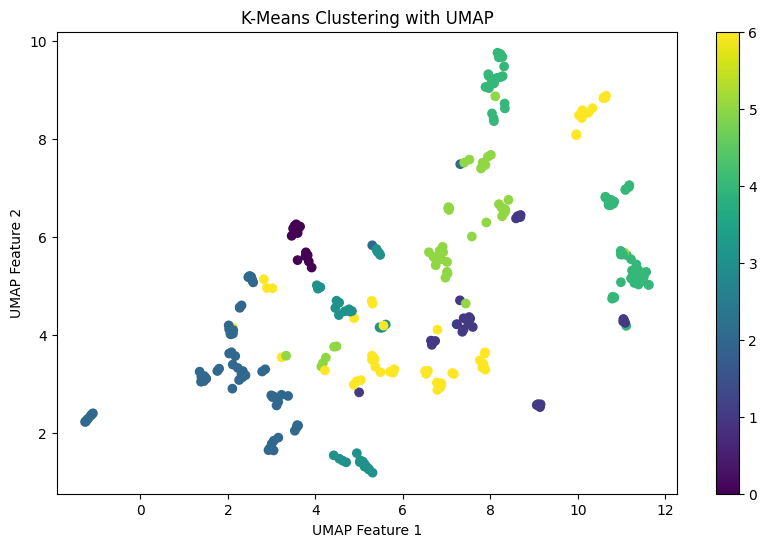

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


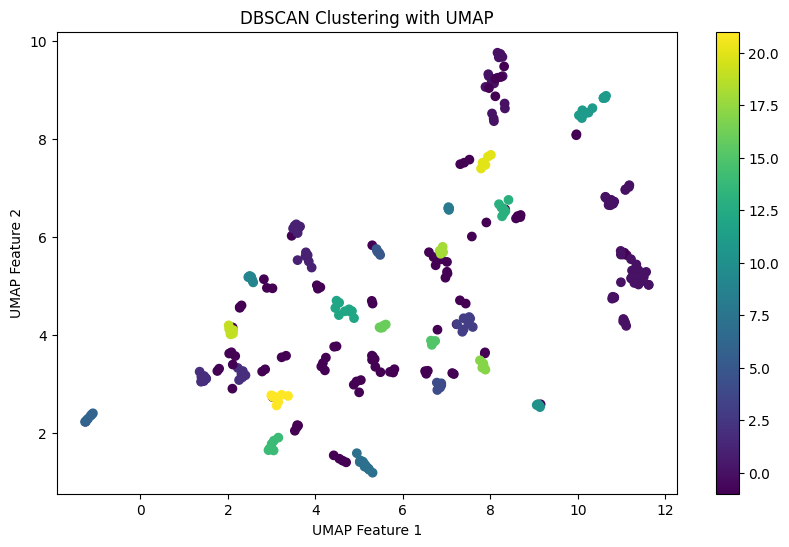

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


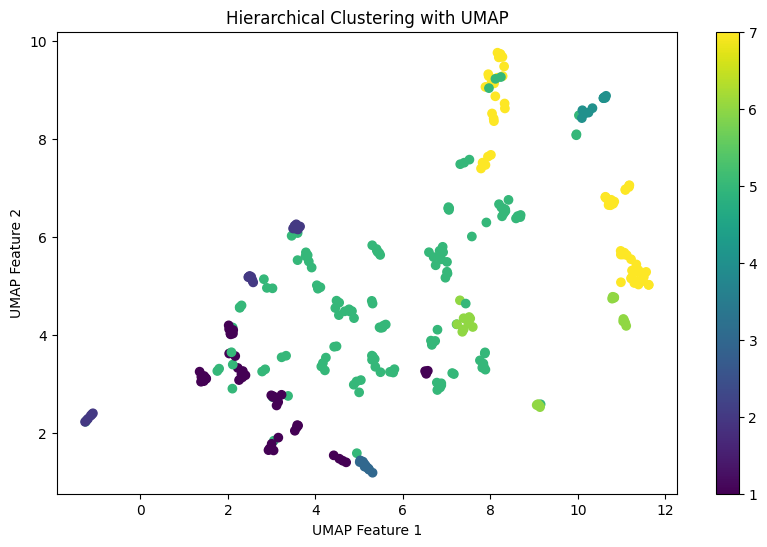

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


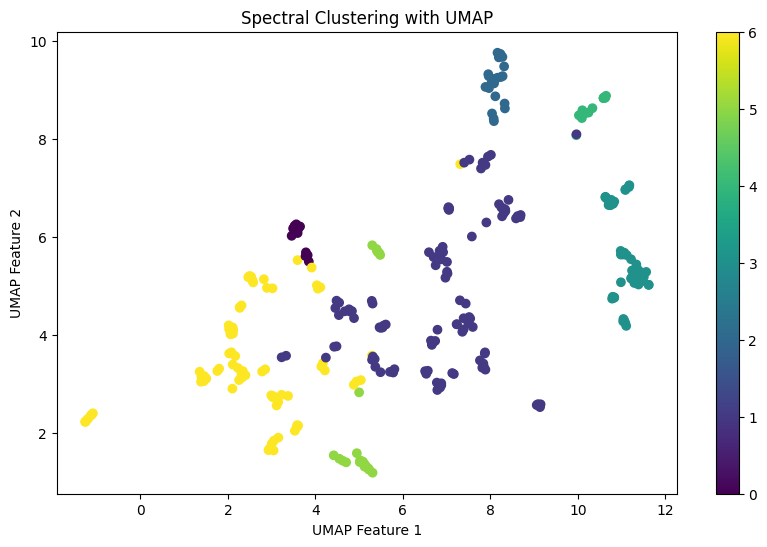

In [139]:
 visualize_clusters(embeddings, dbscan_clusters, hierarchical_clusters, kmeans_clusters, spectral_clusters)

In [140]:
main_clustering_and_evaluation(embeddings, cluster_count)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


dbscan Silhouette: 0.19565365531266612, dbscan Davies-Bouldin: 1.8466258393268358
hierarchical Silhouette: 0.08477509870261125, hierarchical Davies-Bouldin: 2.794224467990209
kmeans Silhouette: 0.09491668082332858, kmeans Davies-Bouldin: 2.974605968412386
spectral Silhouette: 0.08073416839936377, spectral Davies-Bouldin: 2.8316464852922896


Visualization Discrepancy: UMAP reduces dimensionality for visualization and sometimes can make clusters appear more separated than they are in high-dimensional space. The clustering algorithms use the high-dimensional space where clusters might not be as clear-cut.

so it will be because of the dimensionality reduction i assume. my datas are complex and there is no structure in it. so an overlapping is clear. Im just surprised, why it's quite clear separated in umap but not in score then...
if silhouette uses the whole complexitiy (no dim reduction) and umap uses dim reduction. i assume this will be the reason and this would make even sense.
without reduction, they can be quite similar the tickets. but if ouy reduce the dims, there maybe get a clearer view of what the real differencies are.

In [ ]:
# Define an interactive method to set configurations
def run_analysis(data_key, embedding_key, cluster_key):
    df = load_data(data_config[data_key])
    df_preprocessed = preprocess_data(df)
    embeddings = get_embeddings(small_initial, df_preprocessed['cleaned_information'])
    clusters = cluster_data(clustering_config[cluster_key], embeddings)
    scores = evaluate_clusters(embeddings, clusters)
    visualize_clusters(embeddings, clusters)
    # Here you would log/display the scores for comparison

# Create widgets for interactivity
widgets.interact(run_analysis,
                 data_key=widgets.Dropdown(options=data_config.keys()),
                 embedding_key=widgets.Dropdown(options=embedding_config.keys()),
                 cluster_key=widgets.Dropdown(options=clustering_config.keys()))

